In [1]:
import torch
import numpy as np
import scipy.stats
from torch.distributions import constraints, MultivariateNormal
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.util import get_rng_state

In [2]:
p = 0.6
n_sample = 1000
mask = dist.Bernoulli(probs=p).sample((n_sample,))
loc1, loc2 = -4.0, 3.0
scale = 0.5
data = dist.MaskedMixture(mask.bool(),
                         dist.Normal(loc1, scale),
                         dist.Normal(loc2, scale)).sample()

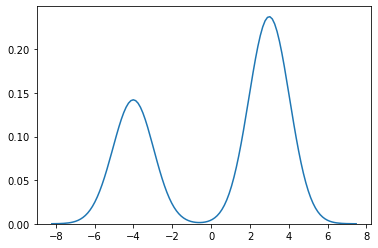

In [3]:
sns.kdeplot(data.numpy())

In [4]:
def model(data):
    weights = pyro.param('weights', torch.tensor(0.5))
    locs = pyro.param('locs', torch.randn(2,))
    with pyro.plate('data', len(data)):
        assignment = pyro.sample('assignment', dist.Bernoulli(weights)).long()
        pyro.sample('obs', dist.Normal(locs[assignment], 1.0))

T = 0.1
def guide(data):
    with pyro.plate('data', len(data)):
        alpha = pyro.param('alpha', torch.ones(len(data)) * 0.5, constraints.unit_interval)
        pyro.sample('assignment', dist.RelaxedBernoulliStraightThrough(torch.tensor(T), probs=alpha))
        
def train(data, svi, num_iterations):
    losses = []
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)
    return losses

In [5]:
def initialize(seed, data, model, guide, optim):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    svi = SVI(model, guide, optim, Trace_ELBO(num_particles=50))
    return svi.loss(model, guide, data)

In [10]:
n_iter = 100
pyro.clear_param_store()
optim = Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
loss, seed = min(
    [(initialize(seed, data, model, guide, optim),seed) for seed in range(100)]
)
pyro.set_rng_seed(seed)
svi = SVI(model, guide, optim, loss=Trace_ELBO(num_particles=50))
losses = train(data, svi, n_iter)

In [11]:
losses

[8301.221166992187,
 8359.401190185548,
 8351.782446289064,
 8313.060854492185,
 8353.570922851562,
 8351.52700317383,
 8384.403093261719,
 8333.670771484374,
 8321.627341308593,
 8349.871146240232,
 8347.643099365236,
 8329.943636474609,
 8341.798170166016,
 8335.40532348633,
 8417.882100830078,
 8366.023520507813,
 8397.120811767574,
 8365.07088623047,
 8360.192524414064,
 8354.46916748047,
 8389.71432373047,
 8355.344200439453,
 8361.771667480469,
 8383.462709960937,
 8393.029584960936,
 8348.78214477539,
 8323.784959716799,
 8347.696606445312,
 8384.485104980467,
 8389.949974365232,
 8341.34476196289,
 8327.366844482422,
 8395.607799072266,
 8383.569150390626,
 8364.345273437502,
 8374.757668457036,
 8352.202225341798,
 8358.441787109376,
 8391.80740722656,
 8362.24583251953,
 8365.5338684082,
 8406.083044433593,
 8362.965572509764,
 8341.593034667967,
 8372.929951171875,
 8409.190638427735,
 8410.711712646485,
 8356.96126220703,
 8361.428944091796,
 8448.825388183594,
 8367.963818